In [13]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



# [Dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

* `__len__` so that len(dataset) returns the size of the dataset.
* `__getitem__` to support the indexing such that `dataset[i]` can be used to get i th sample

We will read the csv in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict `{'image': image, 'landmarks': landmarks}`. Our dataset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [2]:
class symsimDataset(Dataset):
    def __init__(self, root_dir = 'data/symsim/', transform = transform):
        """
        In memory load dataset
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        import anndata
        from scipy.sparse import csr_matrix
        import scvelo as scv 
        import pandas as pd
        from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
        from sklearn.decomposition import PCA
        from sklearn.pipeline import Pipeline
        from sklearn.neighbors import kneighbors_graph

        self.root_dir = root_dir
        self.transform = transform
        start = 25
        end = 75
        count = 2 * np.arange(start,end) + 1
        files = ['branch'+str(x) + '/' for x in count]
        data_list = []
        n_tops = 305

        self.expressionData = []

        for file_name in files:
            X_unspliced = pd.read_csv(root_dir + file_name + "unspliced_counts.txt", sep="\t",header=None).to_numpy().T
            X_spliced = pd.read_csv(root_dir + file_name + "spliced_counts.txt", sep = "\t",header=None).to_numpy().T
            true_velo = pd.read_csv(root_dir + file_name + "true_velo.txt", sep="\t",header=None).to_numpy().T
            true_time = pd.read_csv(root_dir + file_name + "true_time.txt", lineterminator="\n",header=None).to_numpy().squeeze()
            X_obs = pd.DataFrame(data=true_time, index = ['cell_' + str(x) for x in range(X_unspliced.shape[0])], columns = ['sim_time'])

            adata = anndata.AnnData(X = csr_matrix(X_spliced),
                            obs = X_obs,
                            layers = dict(
                                unspliced = csr_matrix(X_unspliced),
                                spliced = csr_matrix(X_spliced),
                                true_velo = true_velo
                            ))
            
            scv.pp.filter_genes_dispersion(adata, n_top_genes=n_tops)
            adata = adata[:,:300]
            
            scv.pp.normalize_per_cell(adata)
            scv.pp.log1p(adata)

            scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
            scv.tl.velocity(adata, mode='stochastic')            
            velo_matrix = adata.layers["velocity"].copy()
            X_spliced = adata.X.toarray()

            pipeline = Pipeline([('pca', PCA(n_components=30, svd_solver='arpack'))])
            X_pca = pipeline.fit_transform(X_spliced)

            X_pre = X_spliced + velo_matrix

            X_pca_pre = pipeline.transform(X_pre)
            velo_pca = X_pca_pre - X_pca

            directed_conn = kneighbors_graph(X_pca, n_neighbors=10, mode='connectivity', include_self=False).toarray()
            conn = directed_conn + directed_conn.T
            conn[conn.nonzero()[0],conn.nonzero()[1]] = 1

            # X_spliced is original, X_pca is after pca
            x = X_spliced.copy()
            x = StandardScaler().fit_transform(x)
            
            v = StandardScaler().fit_transform(X_pre)

            # Simulation time label
            y = X_obs['sim_time'].to_numpy().reshape((-1, 1))
            scaler = MinMaxScaler((0, 1))
            scaler.fit(y)
            y = scaler.transform(y).reshape(-1, 1)
            
            # adjacency matrix
            adj = np.full_like(conn, np.nan)
            for i in range(conn.shape[0]):
                # self loop
                adj[i][i] = 0

                indices = conn[i,:].nonzero()[0]
                for k in indices:
                    diff = X_pca[i, :] - X_pca[k, :] # 1,d
                    distance = np.linalg.norm(diff, ord=2) #1
                    penalty = np.dot(diff, velo_pca[k, :, None]) / np.linalg.norm(velo_pca[k,:], ord=2) / distance
                    penalty = 0 if np.isnan(penalty) else penalty
                    adj[i][k] = penalty

            # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html
            X_obs = X_obs.to_dict('split')
            sample = {"x": x, "v": v, "y": y, "adj": adj, "obs": X_obs}

            # if self.transform != None
            if self.transform:
                sample = self.transform(sample)
        
            self.expressionData.append(sample)
        print("Done with bifurcating!")
                       

    def __len__(self):
        return len(self.expressionData)
    
    def __getitem__(self, idx):
        return self.expressionData[idx]


In [24]:
class symsimDataset_tree(Dataset):
    def __init__(self, root_dir = 'data/symsim/', transform = transform):
        """
        In memory load dataset
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        import anndata
        from scipy.sparse import csr_matrix
        import scvelo as scv 
        import pandas as pd
        from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
        from sklearn.decomposition import PCA
        from sklearn.pipeline import Pipeline
        from sklearn.neighbors import kneighbors_graph

        self.root_dir = root_dir
        self.transform = transform
        start = 25
        end = 75
        count = 2 * np.arange(start,end) + 1
        files = ['branch'+str(x) + '/' for x in count]
        data_list = []
        n_tops = 305

        self.expressionData = []

        # tree
        tree_files = ['tree/rand'+str(i)+'/' for i in range(1,101)]
        for file_name in tree_files:
            X_unspliced = pd.read_csv(root_dir + file_name + "unspliced_counts.txt", sep="\t",header=None).to_numpy().T
            X_spliced = pd.read_csv(root_dir + file_name + "spliced_counts.txt", sep = "\t",header=None).to_numpy().T
            true_velo = pd.read_csv(root_dir + file_name + "true_velo.txt", sep="\t",header=None).to_numpy().T
            true_time = pd.read_csv(root_dir + file_name + "cell_labels.txt", sep = "\t",lineterminator="\n").to_numpy()
            X_obs = pd.DataFrame(data=true_time, index = ['cell_' + str(x) for x in range(X_unspliced.shape[0])], columns = ['back_bone','sim_time'])


            adata = anndata.AnnData(X = csr_matrix(X_spliced),
                            obs = X_obs,
                            layers = dict(
                                unspliced = csr_matrix(X_unspliced),
                                spliced = csr_matrix(X_spliced),
                                true_velo = true_velo
                            ))

            # scv.pp.filter_and_normalize(adata, min_shared_counts=0, n_top_genes=n_tops)
            scv.pp.filter_genes_dispersion(adata, n_top_genes=n_tops)
            adata = adata[:,:300]
            print(adata.n_vars)
            scv.pp.normalize_per_cell(adata)
            scv.pp.log1p(adata)

            # compute velocity
            scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
            scv.tl.velocity(adata, mode='stochastic')            
            velo_matrix = adata.layers["velocity"].copy()

            X_spliced = adata.X.toarray()

            # pipeline = Pipeline([('pca', PCA(n_components=80, svd_solver='arpack'))])
            pipeline = Pipeline([('pca', PCA(n_components=30, svd_solver='arpack'))])
            X_pca = pipeline.fit_transform(X_spliced)

            # X_pre = X_spliced + velo_matrix/np.linalg.norm(velo_matrix,axis=1)[:,None]*3
            X_pre = X_spliced + velo_matrix

            X_pca_pre = pipeline.transform(X_pre)
            velo_pca = X_pca_pre - X_pca

            directed_conn = kneighbors_graph(X_pca, n_neighbors=10, mode='connectivity', include_self=False).toarray()
            conn = directed_conn + directed_conn.T
            conn[conn.nonzero()[0],conn.nonzero()[1]] = 1

            # X_spliced is original, X_pca is after pca
            x = X_spliced.copy()
            x = StandardScaler().fit_transform(x)

            # X_pca_pre is after pca
            v = StandardScaler().fit_transform(X_pre)

            # Simulation time label
            y = X_obs['sim_time'].to_numpy().reshape((-1, 1))
            scaler = MinMaxScaler((0, 1))
            scaler.fit(y)
            y = scaler.transform(y).reshape(-1, 1)

            adj = np.full_like(conn, np.nan)
            for i in range(conn.shape[0]):
                # self loop
                adj[i][i] = 0

                indices = conn[i,:].nonzero()[0]
                for k in indices:
                    diff = X_pca[i, :] - X_pca[k, :] # 1,d
                    distance = np.linalg.norm(diff, ord=2) #1
                
                    penalty = np.dot(diff, velo_pca[k, :, None]) / np.linalg.norm(velo_pca[k,:], ord=2) / distance
                    penalty = 0 if np.isnan(penalty) else penalty
                    adj[i][k] = penalty

            # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_dict.html
            X_obs = X_obs.to_dict('split')
            sample = {"x": x, "v": v, "y": y, "adj": adj, "obs": X_obs}

            # if self.transform != None
            if self.transform:
                sample = self.transform(sample)
        
            self.expressionData.append(sample)



    def __len__(self):
        return len(self.expressionData)
    
    def __getitem__(self, idx):
        return self.expressionData[idx]


# Transforms

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create three transforms:

* `Rescale`: to scale the image
* `RandomCrop`: to crop from image randomly. This is data augmentation.
* `ToTensor`: to convert the numpy images to torch images (we need to swap axes).

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement `__call__` method and if required, `__init__` method. We can then use a transform like this:

```
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

In [27]:
class transform(object):
    def __call__(self, sample):
        from scipy.linalg import block_diag
        import torch.nn.functional as F

        sample["x"] = torch.FloatTensor(sample["x"])
        sample["v"] = torch.FloatTensor(sample["v"])
        sample["y"] = torch.FloatTensor(sample["y"])
        if len(sample["adj"]) == 1:
            adj = torch.FloatTensor(sample["adj"]).view(sample["x"].shape[0], sample["x"].shape[0])
        else:
            adj = torch.FloatTensor(block_diag(*[i[0] for i in sample["adj"]]))
    
        # coded in the dataset generation process
        adj = F.sigmoid(adj)
        adj[torch.isnan(adj)] = 0
        adj = adj * 4
        sample["adj"] = adj

        return sample



# Iterating through the dataset

Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly
Transforms are applied on the read image
Since one of the transforms is random, data is augmentated on sampling
We can iterate over the created dataset with a for i in range loop as before.

In [9]:
symsim_dataset_tensor_ver = symsimDataset(root_dir = 'data/symsim/', transform = transform())

00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Trying to set attribute `.obs` of view, copying.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Trying to set attribute `.obs` of view, copying.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata

In [5]:
# print(len(symsim_dataset_tensor_ver))
# torch.save(symsim_dataset_tensor_ver, "./symsim_data_bifur.pth")
symsim_dataset_tensor_ver = torch.load("./symsim_data_bifur.pth")

However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using `collate_fn`. However, default collate should work fine for most use cases.

In [6]:
class FCModel(nn.Module):
    
    def __init__(self, in_channels, device):
        super(FCModel, self).__init__()
        self.device = device

        self.lin1 = nn.Linear(in_channels, 64)
        self.lin2 = nn.Linear(64, 64)
        self.lin3 = nn.Linear(64, 1)
    
    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.lin3.reset_parameters()

    def forward(self, data):
        x = data["x"].float()
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.sigmoid(self.lin3(x))
        return x


In [7]:
t = np.arange(1,10)
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40)

val_mask = [0, 10, 20, 30, 40]

train_set = [symsim_dataset_tensor_ver[train_idx] for train_idx in train_mask]
val_set = [symsim_dataset_tensor_ver[val_idx] for val_idx in val_mask]

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)


In [21]:
from sklearn.metrics import mean_squared_error
def train(train_loader):
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        
        optimizer.zero_grad()
        output = model(data)

        label = data["y"].to(device)
        loss = torch.sqrt(mse(output, label)) # + lamb * loss_net
        loss.backward()
        total_loss += data["x"].shape[0] * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        label = data["y"].detach().cpu().numpy().reshape(-1)

        pred = model(data)
        pred = pred.detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return np.sqrt(mean_squared_error(correct, predict))

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCModel(300, device).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(101):
    train_loss = train(train_loader)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.2749, Train: 0.2717, Val: 0.2691
Epoch: 010, Loss: 0.2130, Train: 0.2068, Val: 0.2160
Epoch: 020, Loss: 0.0995, Train: 0.0965, Val: 0.1209
Epoch: 030, Loss: 0.0810, Train: 0.0803, Val: 0.1096
Epoch: 040, Loss: 0.0741, Train: 0.0737, Val: 0.1085
Epoch: 050, Loss: 0.0695, Train: 0.0693, Val: 0.1081
Epoch: 060, Loss: 0.0660, Train: 0.0657, Val: 0.1081
Epoch: 070, Loss: 0.0632, Train: 0.0629, Val: 0.1091
Epoch: 080, Loss: 0.0607, Train: 0.0604, Val: 0.1098
Epoch: 090, Loss: 0.0583, Train: 0.0581, Val: 0.1109
Epoch: 100, Loss: 0.0563, Train: 0.0560, Val: 0.1122


In [28]:
symsim_dataset_tensor_ver = symsimDataset_tree(root_dir = 'data/symsim/', transform = transform())

ents based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Trying to set attribute `.obs` of view, copying.
Skip filtering by dispersion since number of variables are less than `n_top_genes`
300
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Trying to set attribute `.obs` of view, copying.
Skip filtering by dispersion since number of variables are less than `n_top_genes`
300
computing neighbors
    finished (0:00:00) --> added

In [29]:
print(len(symsim_dataset_tensor_ver))
torch.save(symsim_dataset_tensor_ver, "./symsim_data_tree.pth")
symsim_dataset_tensor_ver = torch.load("./symsim_data_tree.pth")

100


In [47]:
t = np.arange(1,10)
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40)

val_mask = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

train_set = [symsim_dataset_tensor_ver[train_idx] for train_idx in train_mask]
val_set = [symsim_dataset_tensor_ver[val_idx] for val_idx in val_mask]

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)


In [48]:
def pca_op(X, n_comps = 2, standardize  = True):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    if standardize:
        pipeline = Pipeline([('standardize', StandardScaler()), ('pca', PCA(n_components=n_comps))])
    else:
        pipeline = Pipeline([('pca', PCA(n_components=n_comps))])
    X_pca = pipeline.fit_transform(X)
    return X_pca

In [49]:
def scatter(data, figsize = (15,5), method = 'pca'):
    # X should be something before pca
    if isinstance(data["x"], torch.Tensor):
        X = data["x"].numpy().squeeze()
    elif isinstance(data["x"], np.ndarray):
        X = data["x"].squeeze()
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data["y"], torch.Tensor):
        y = data["y"].numpy().squeeze()
    elif isinstance(data["y"], np.ndarray):
        y = data["y"]
    else:
        raise ValueError('tensor or numpy array')
    X_pca = pca_op(X, n_comps = 2, standardize=False)

    
    pred = model(data)
    pred = pred.detach().cpu().numpy().reshape(-1)
    rmse = np.sqrt(mean_squared_error(y, pred))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.set_title("Prediction, RMSE="+str(rmse)[:5])
    ax2.set_title("Simulation Time")
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax2)
    plt.figure(figsize=figsize)
    plt.show()

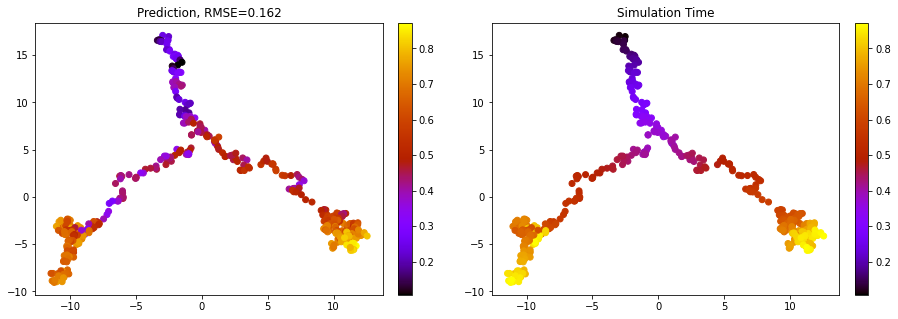

<Figure size 1080x360 with 0 Axes>

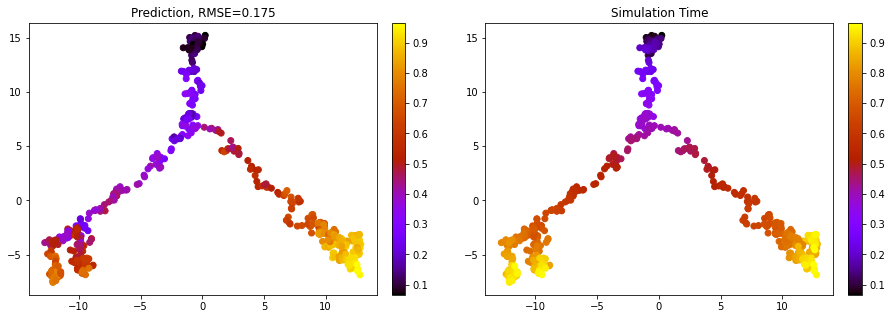

<Figure size 1080x360 with 0 Axes>

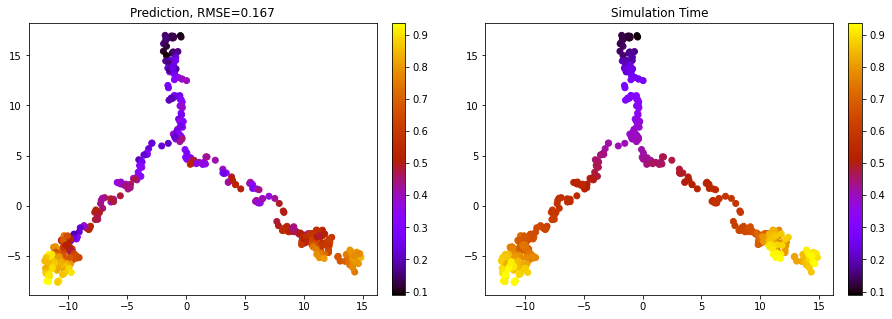

<Figure size 1080x360 with 0 Axes>

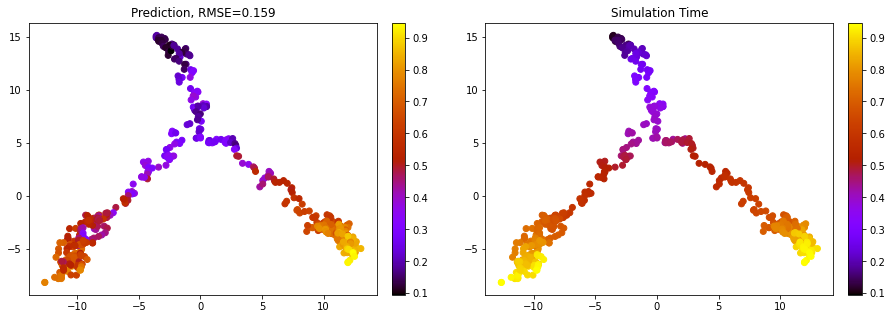

<Figure size 1080x360 with 0 Axes>

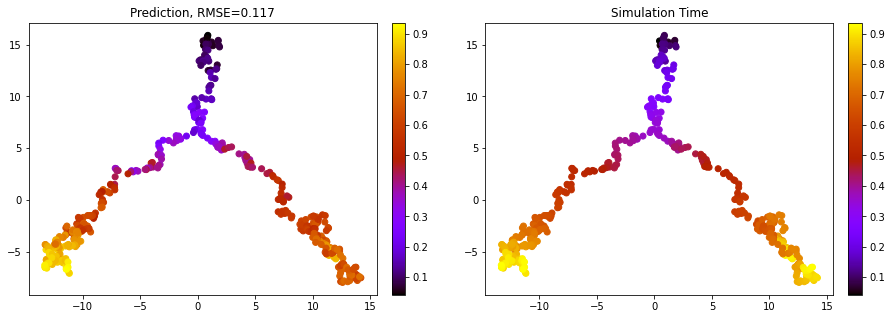

<Figure size 1080x360 with 0 Axes>

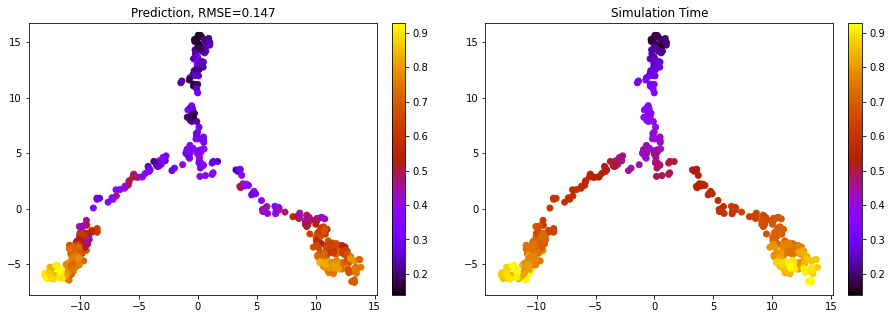

<Figure size 1080x360 with 0 Axes>

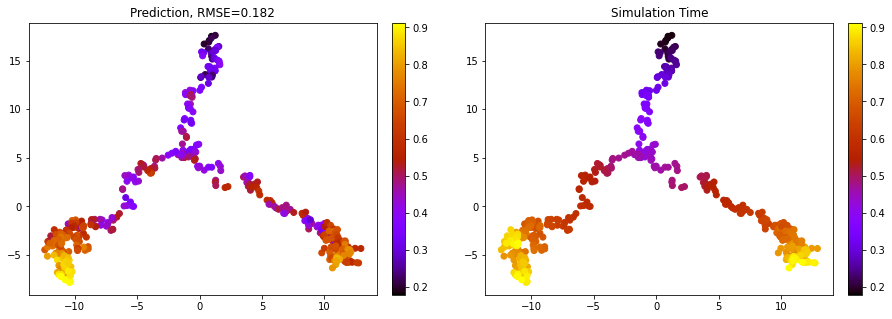

<Figure size 1080x360 with 0 Axes>

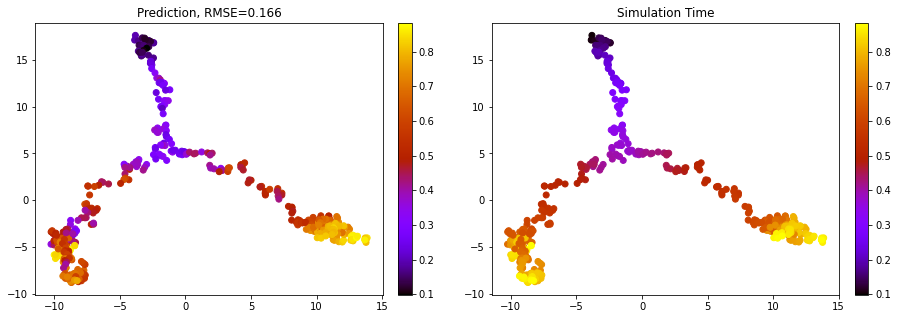

<Figure size 1080x360 with 0 Axes>

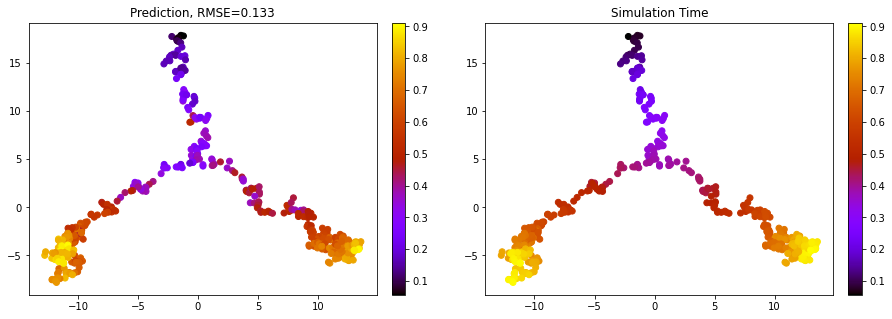

<Figure size 1080x360 with 0 Axes>

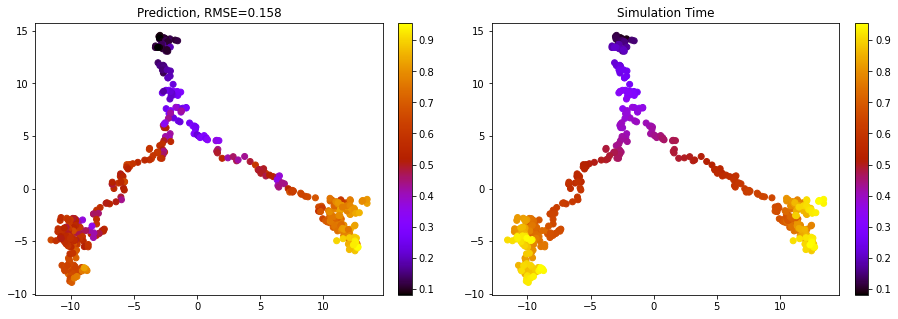

<Figure size 1080x360 with 0 Axes>

In [50]:
for val_data in val_loader:
    scatter(val_data)    